Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

Load dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')

In [3]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  int64  
 1   Customer ID                  10000 non-null  int64  
 2   Transaction Amount           10000 non-null  float64
 3   Transaction Date and Time    10000 non-null  object 
 4   Merchant Category            10000 non-null  object 
 5   Location                     10000 non-null  object 
 6   Previous Transaction Amount  10000 non-null  float64
 7   Time Since Last Transaction  10000 non-null  float64
 8   Device Type                  10000 non-null  object 
 9   Fraud                        10000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


Check for nulls

In [5]:
df.isnull().sum()

Transaction ID                 0
Customer ID                    0
Transaction Amount             0
Transaction Date and Time      0
Merchant Category              0
Location                       0
Previous Transaction Amount    0
Time Since Last Transaction    0
Device Type                    0
Fraud                          0
dtype: int64

In [6]:
df['Fraud'].value_counts()


Fraud
No     8608
Yes    1392
Name: count, dtype: int64

This dataset is imbalanced and the model may not do a great job of predicting fraud, but will be able to predict what is not fraud better. 

# Exploratory Data Analysis

In [7]:
df.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud'],
      dtype='object')

**Univariate Analysis**

Transaction amount distribution

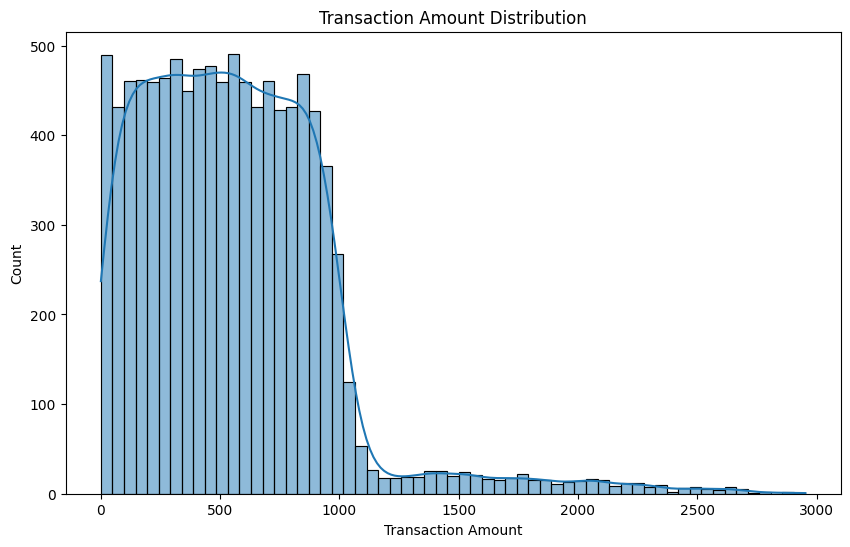

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Transaction Amount'], kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

This data is very positively skewed with a long tail on the right

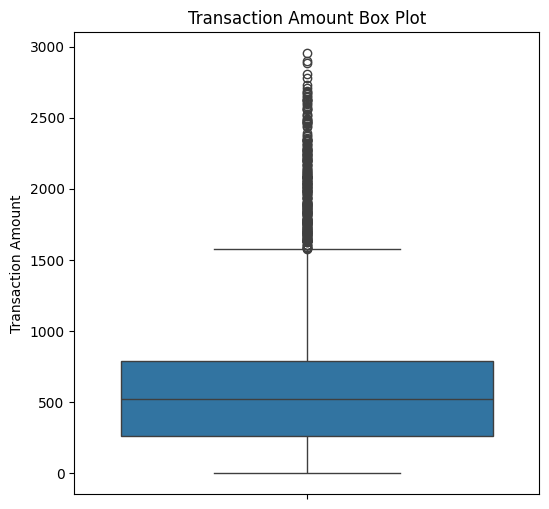

In [9]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['Transaction Amount'])
plt.title('Transaction Amount Box Plot')
plt.show()

Previous transaction amount distribution

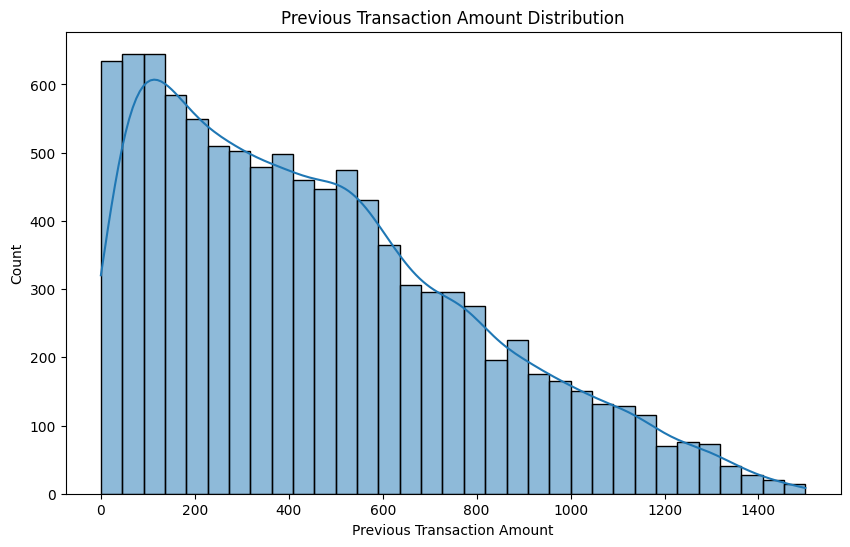

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Previous Transaction Amount'], kde=True)
plt.title('Previous Transaction Amount Distribution')
plt.show()

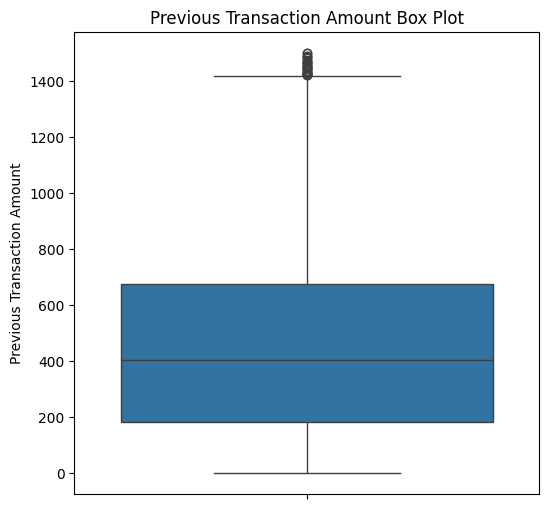

In [11]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['Previous Transaction Amount'])
plt.title('Previous Transaction Amount Box Plot')
plt.show()

This is positively skewed with a bit more outliers in the higher transaction amounts but not huge outliers.

Time since last transaction distribution

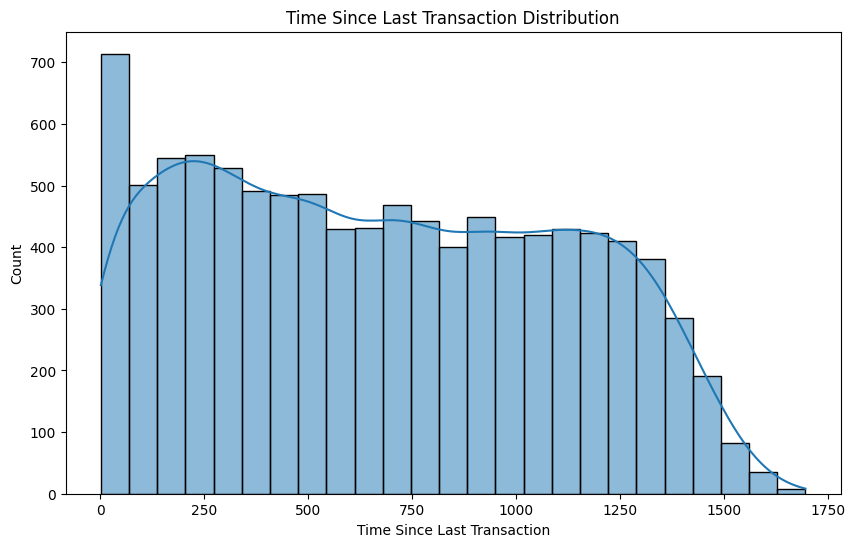

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Time Since Last Transaction'], kde=True)
plt.title('Time Since Last Transaction Distribution')
plt.show()

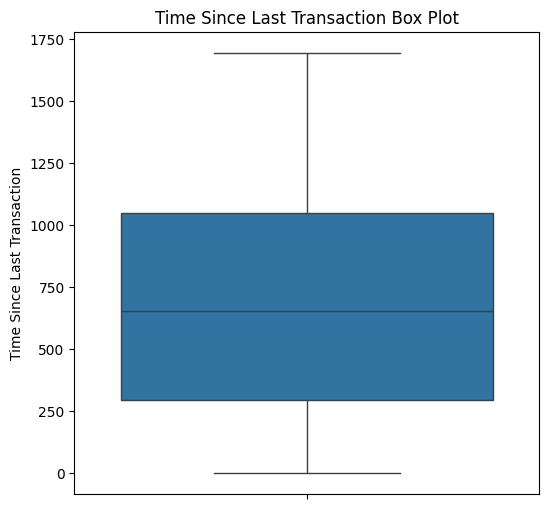

In [13]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['Time Since Last Transaction'])
plt.title('Time Since Last Transaction Box Plot')
plt.show()

This is more evenly distributed, but a tiny bit more positively skewed and does not have any outliers.

Merchant category

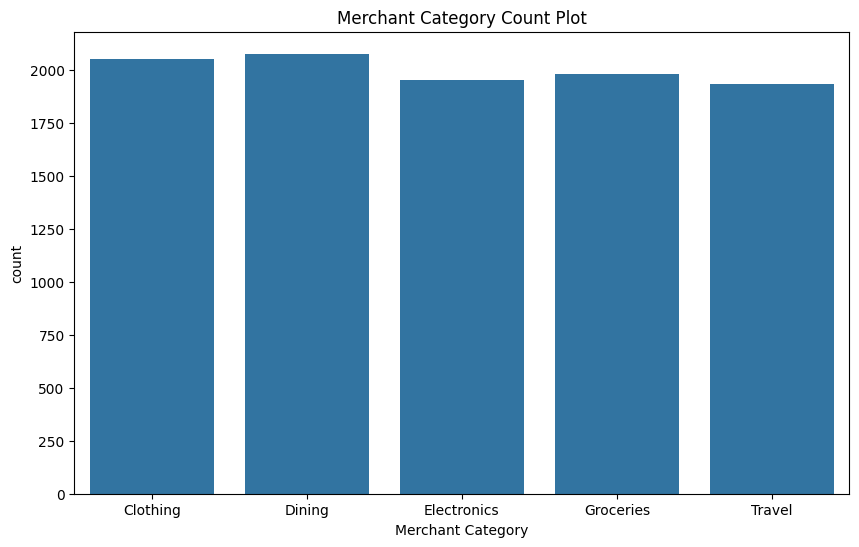

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Merchant Category'])
plt.title('Merchant Category Count Plot')
plt.show()

Merchant category is distributed pretty evenly distributed

Location

In [15]:
df['Location'].value_counts()

Location
Houston          2373
Los Angeles      1956
Chicago          1915
San Francisco    1890
New York         1866
Name: count, dtype: int64

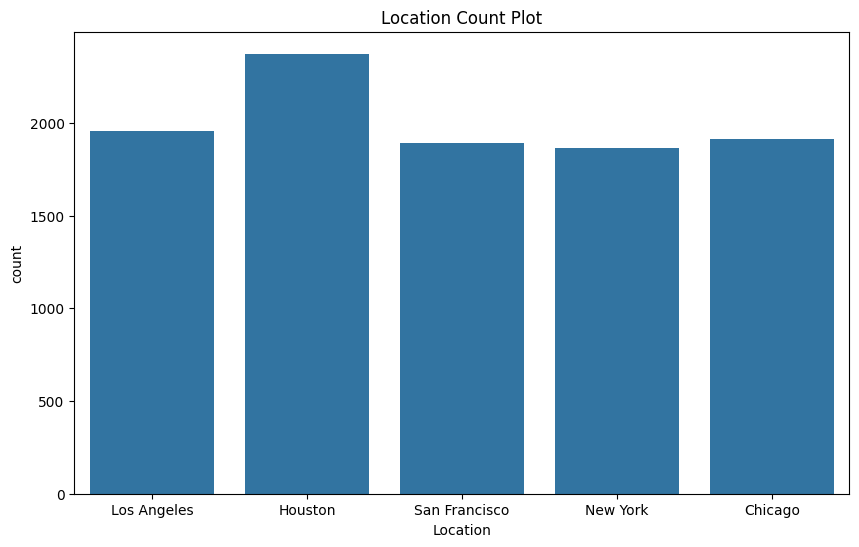

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Location'])
plt.title('Location Count Plot')
plt.show()

It is pretty evenly distributed, with a little bit more customers from Houston.

Device type 

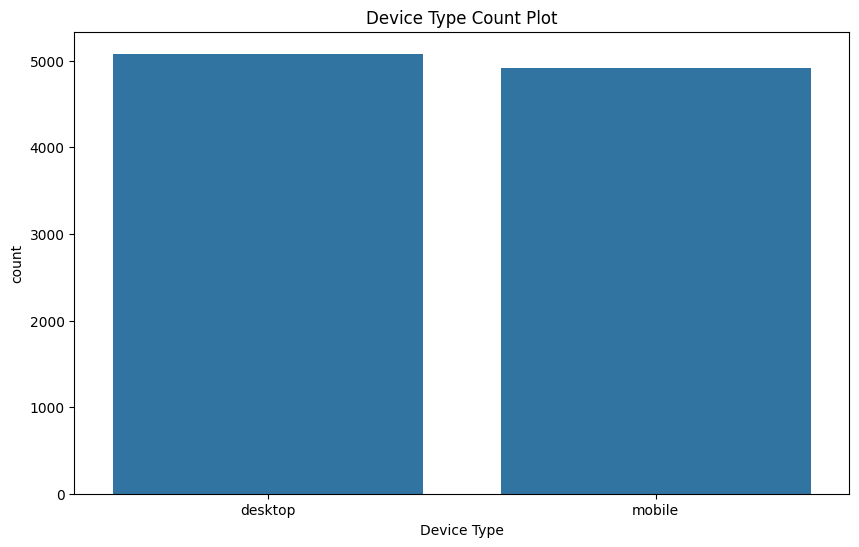

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Device Type'])
plt.title('Device Type Count Plot')
plt.show()

Pretty even. Not really one device used more signficantly than the other.

Fraud

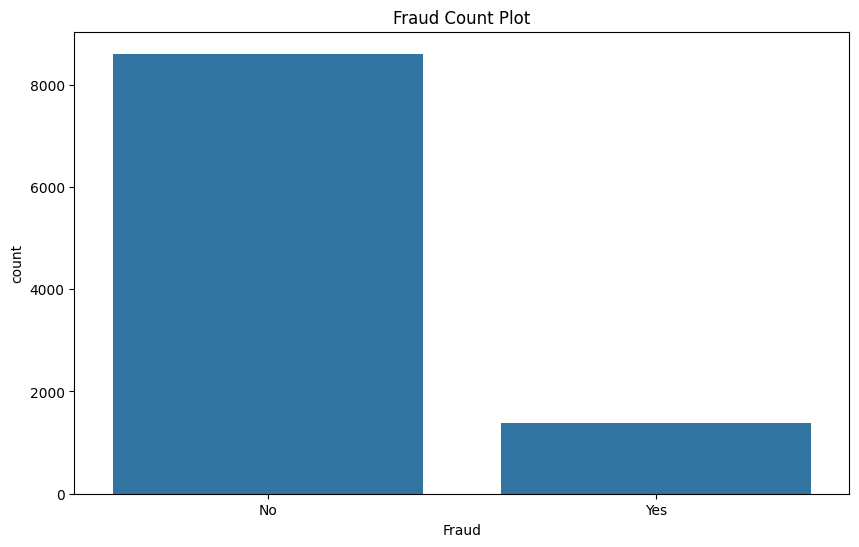

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Fraud'])
plt.title('Fraud Count Plot')
plt.show()

Imbalanced

**Bivariate Analysis**

Fraud based on merchant category


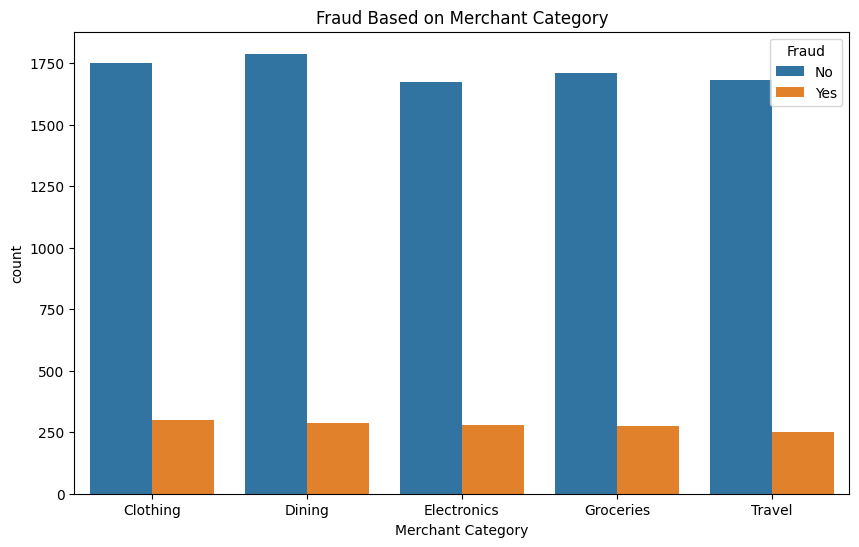

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Merchant Category', hue='Fraud', data=df)
plt.title('Fraud Based on Merchant Category')
plt.show()

It is pretty evenly distributed across.

Fraud based on location

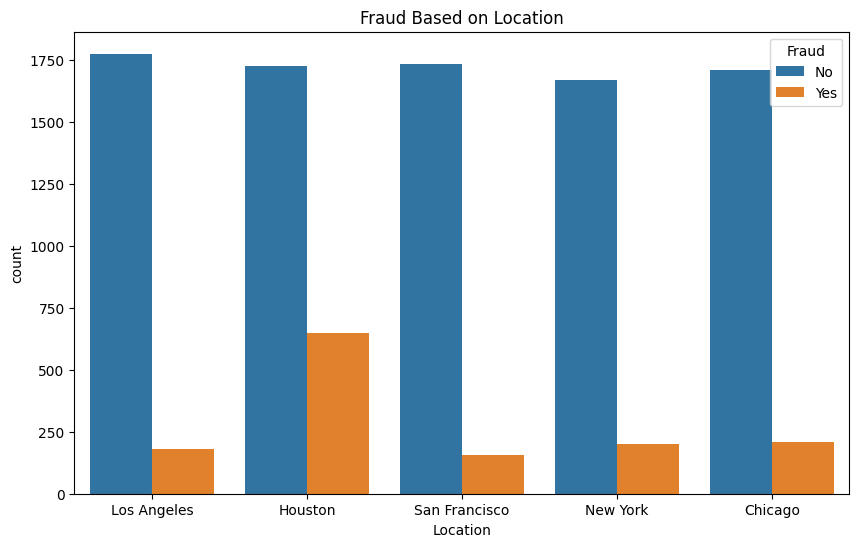

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Location', hue='Fraud', data=df)
plt.title('Fraud Based on Location')
plt.show()

More fraud happening in Houston. 

It could raise some questions about maybe safety and how at risk people may be with getting their card stolen.

Fraud based on device

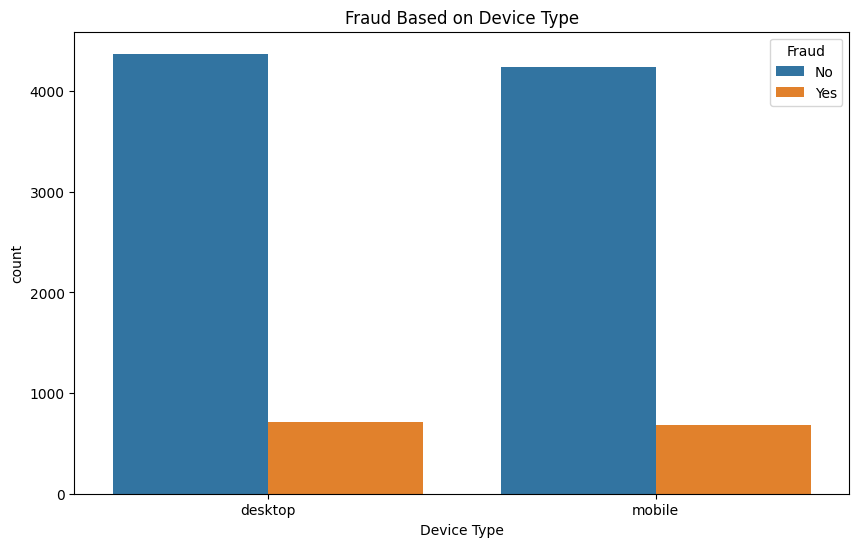

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Device Type', hue='Fraud', data=df)
plt.title('Fraud Based on Device Type')
plt.show()

No significant differences.

Fraud based on transaction amount

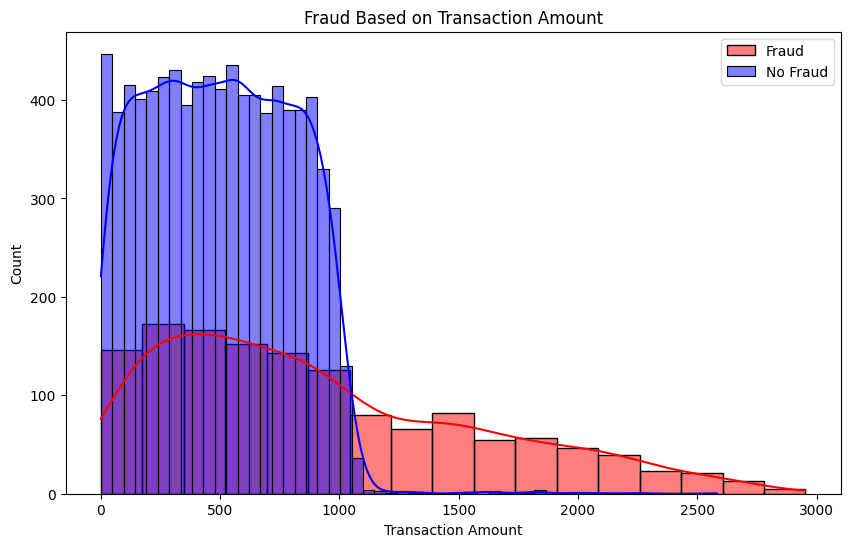

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Fraud'] == 'Yes']['Transaction Amount'], kde=True, color='red', label='Fraud')
sns.histplot(df[df['Fraud'] == 'No']['Transaction Amount'], kde=True, color='blue', label='No Fraud')
plt.title('Fraud Based on Transaction Amount')
plt.legend()
plt.show()

Based on this, it looks like a lot of fraud happens when the transaction amounts are higher, which makes sense as people who steal credit card info are more likely to buy things they would not want to pay for themselves. 

Fraud based on previous transaction amount

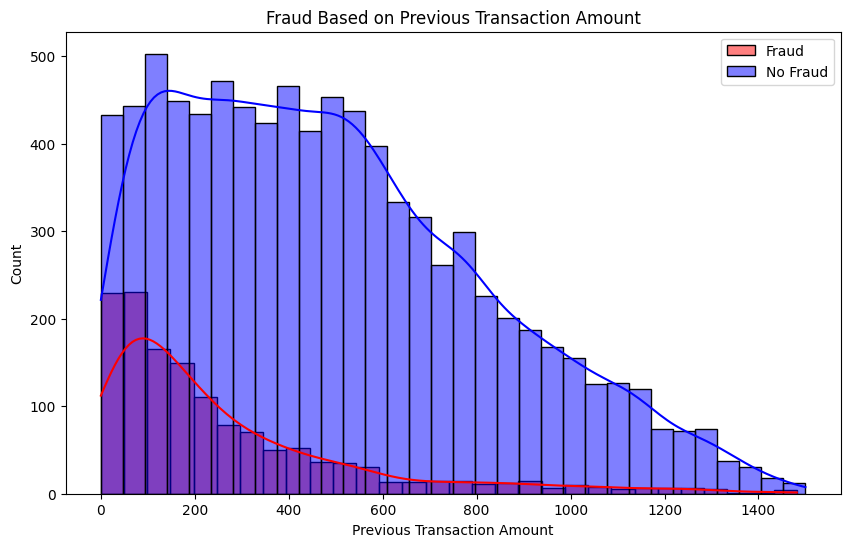

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Fraud'] == 'Yes']['Previous Transaction Amount'], kde=True, color='red', label='Fraud')
sns.histplot(df[df['Fraud'] == 'No']['Previous Transaction Amount'], kde=True, color='blue', label='No Fraud')
plt.title('Fraud Based on Previous Transaction Amount')
plt.legend()
plt.show()

Similarly, with fraud happening with high transaction amounts, in this graph we see that majority of fraud happens when previous transaction amounts are lower, which could be based on a customers typical spending pattern, if they suddenly have a high transaction after normally having lower ones it might signal or trigger fraud.

Fraud based on time since last transaction

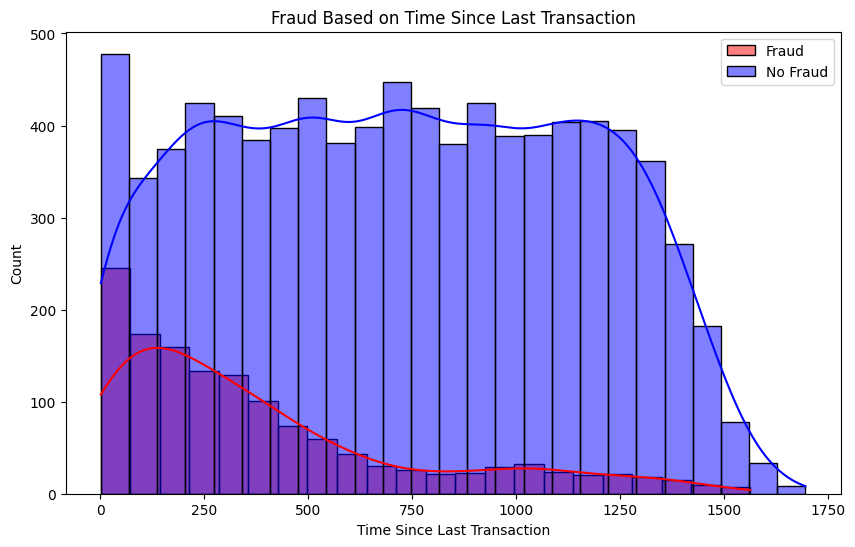

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Fraud'] == 'Yes']['Time Since Last Transaction'], kde=True, color='red', label='Fraud')
sns.histplot(df[df['Fraud'] == 'No']['Time Since Last Transaction'], kde=True, color='blue', label='No Fraud')
plt.title('Fraud Based on Time Since Last Transaction')
plt.legend()
plt.show()

This graph indicates that fraud happens a lot to people who have made transactions more recently can maybe mean that people who tend to buy more frequently and are inputting their card information more often might be at a greater risk for fraud.

# Hypothesis
Features such as location, transaction amount, previous transaction amount and the time since last transaction have an affect on whether or not a transaction will be fraudulent.

# Feature Engineering

In [26]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  int64  
 1   Customer ID                  10000 non-null  int64  
 2   Transaction Amount           10000 non-null  float64
 3   Transaction Date and Time    10000 non-null  object 
 4   Merchant Category            10000 non-null  object 
 5   Location                     10000 non-null  object 
 6   Previous Transaction Amount  10000 non-null  float64
 7   Time Since Last Transaction  10000 non-null  float64
 8   Device Type                  10000 non-null  object 
 9   Fraud                        10000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


Convert transaction date and time to correct data type

In [28]:
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Transaction ID               10000 non-null  int64         
 1   Customer ID                  10000 non-null  int64         
 2   Transaction Amount           10000 non-null  float64       
 3   Transaction Date and Time    10000 non-null  datetime64[ns]
 4   Merchant Category            10000 non-null  object        
 5   Location                     10000 non-null  object        
 6   Previous Transaction Amount  10000 non-null  float64       
 7   Time Since Last Transaction  10000 non-null  float64       
 8   Device Type                  10000 non-null  object        
 9   Fraud                        10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 781.4+ KB


Want to make a new column for difference in transaction amount and previous transaction amount that way, we can look at whether or not large differences in spending signal fraud and how large.

In [30]:
df['Amount Difference'] = df['Transaction Amount'] - df['Previous Transaction Amount']

In [31]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,Amount Difference
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No,79.973391
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No,66.826182
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No,233.235965
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No,-353.059489
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No,40.791565


One-hot encoding for categorical variables

In [32]:
df= pd.get_dummies(df, columns=['Merchant Category', 'Location',  'Device Type', 'Fraud'], drop_first=True)

# Model Building

Define X features and y target

Also droppping Transaction Amount and Previous Transaction Amount since I already have the amount difference and want to avoid overfitting 

In [33]:
X = df.drop(columns=['Customer ID', 'Transaction ID', 'Fraud_Yes','Transaction Amount', 'Transaction Date and Time', 'Previous Transaction Amount'])
y = df['Fraud_Yes']

Split the data into training and reserve 30% for testing

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Scale Data

In [35]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit(X_train).transform(X_test)

In [36]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

,Time Since Last Transaction,Amount Difference,Merchant Category_Dining,Merchant Category_Electronics,Merchant Category_Groceries,Merchant Category_Travel,Location_Houston,Location_Los Angeles,Location_New York,Location_San Francisco,Device Type_mobile
0,0.370784,0.123113,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.271428,0.230724,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.407019,0.176676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.756463,0.133771,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.501562,0.220527,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


Initialize Models

Adding a balanced weight class to models since it is an imbalanced dataset

In [37]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
knn = KNeighborsClassifier()
nb = GaussianNB()
svm = SVC(class_weight='balanced', random_state=42)

Cross Validation scores

In [38]:
logreg_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='accuracy')
dt_scores = cross_val_score(dt, X_train_scaled, y_train, cv=5, scoring='accuracy')
rf_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy')
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
nb_scores = cross_val_score(nb, X_train_scaled, y_train, cv=5, scoring='accuracy')
svm_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='accuracy')

In [39]:
print(np.mean(logreg_scores))
print(np.mean(dt_scores))
print(np.mean(rf_scores))
print(np.mean(knn_scores))
print(np.mean(nb_scores))
print(np.mean(svm_scores))

0.8465714285714286
0.8704285714285713
0.9221428571428572
0.9154285714285715
0.9207142857142857
0.8782857142857143


Based on the cross validation, random forest and naive bayes performed best.

Given that naive bayes may have difficulty in real life predicting independent predictors, I will focus on random forest.

# Random Forest Model

Hyperparameter Tuning for Random Forest

In [40]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

Initialize Grid Search

In [41]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

Fit Grid Search

In [42]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

Find best parameters for random forest

In [43]:
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Train final model with the best parameters

In [44]:
rf_classifier = RandomForestClassifier(
    bootstrap=True,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)

Evaluate final model on the test set

In [45]:
y_pred = rf_classifier.predict(X_test_scaled)

**Performance Metrics**

Accuracy Score

In [46]:
accuracy_score(y_test,y_pred)

0.9236666666666666

Precision Score

In [47]:
precision_score(y_test,y_pred)

0.8461538461538461

Recall Score

In [48]:
recall_score(y_test,y_pred)

0.5225

F1 Score

In [49]:
f1_score(y_test, y_pred)

0.6460587326120556

Classification Report

In [50]:
clf =classification_report(y_test, y_pred)
print(clf)

              precision    recall  f1-score   support

       False       0.93      0.99      0.96      2600
        True       0.85      0.52      0.65       400

    accuracy                           0.92      3000
   macro avg       0.89      0.75      0.80      3000
weighted avg       0.92      0.92      0.92      3000



Confusion Matrix

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[2562   38]
 [ 191  209]]


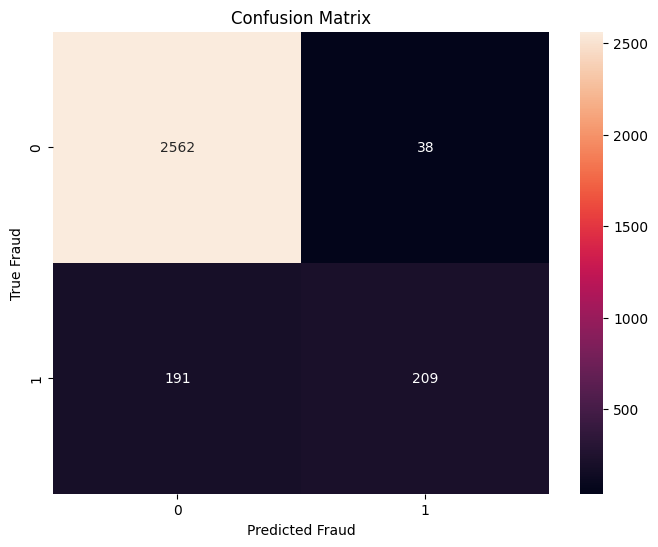

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True Fraud')
plt.xlabel('Predicted Fraud')
plt.title('Confusion Matrix')
plt.show()

It looks like the model is better at predicting non-fraudulent transactions than it is fraudulent, could be due to imbalance the precision score for fraudulent is good (85%).

Meaning that the model predicts when fraudulent activities are actually flagged as fraudulent, reducing false positives.

The recall score is not great, so does an okay job at reducing the number of legitimate transactions flagged as fraud. 

Precision Recall Curve

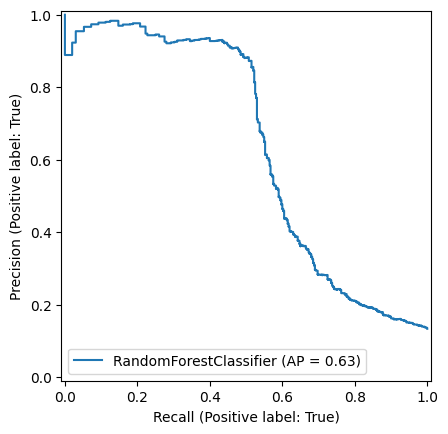

In [53]:
display = PrecisionRecallDisplay.from_estimator(rf_classifier, X_test_scaled, y_test)

Based on the precision-recall curve, if we want a higher recall, we would have a bit of a trade off.

It is good to prioritize precision as it ensure that flagged transactions are indeed fraudulent to reduce false positives, which also enhances customer experience.